# GPT Image Generation with Cost and Time Tracking

This notebook loads an initial image and example image, applies a prompt from a text file to insert/replace objects, and tracks execution time and token costs.

## Setup and Dependencies

# Install required packages

pip install pillow openai -U

In [57]:
import os
import time
import json
import base64
import requests
from PIL import Image
from io import BytesIO
from datetime import datetime
from IPython.display import Image as IPImage, display

In [58]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [59]:
# Initialize OpenAI client
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Configuration and File Paths

In [60]:
# Directory structure
INPUT_DIR = "inputs"
OUTPUT_DIR = "outputs"
PROMPTS_DIR = "prompts"

# Create directories if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROMPTS_DIR, exist_ok=True)

# File paths
INITIAL_IMAGE_PATH = os.path.join(INPUT_DIR, "initial.jpg")
EXAMPLE_IMAGE_PATH = os.path.join(INPUT_DIR, "example.jpg")
PROMPT_FILE_PATH = os.path.join(PROMPTS_DIR, "prompt.txt")
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_DIR, "generated_image.jpg")
RESULTS_LOG_PATH = os.path.join(OUTPUT_DIR, "generation_results.json")

print(f"Directories created:")
print(f"- Input images: {INPUT_DIR}")
print(f"- Output images: {OUTPUT_DIR}")
print(f"- Prompts: {PROMPTS_DIR}")

Directories created:
- Input images: inputs
- Output images: outputs
- Prompts: prompts


## File Loading Functions

In [61]:
def load_prompt_from_file(file_path):
    """Load prompt text from a file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            prompt = file.read().strip()
        print(f"✓ Prompt loaded from {file_path}")
        print(f"Prompt length: {len(prompt)} characters")
        return prompt
    except FileNotFoundError:
        print(f"❌ Prompt file not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading prompt: {e}")
        return None

def load_and_validate_image(file_path):
    """Load and validate an image file."""
    try:
        with open(file_path, 'rb') as file:
            image_data = file.read()
        
        # Validate that it's a valid image
        image = Image.open(BytesIO(image_data))
        print(f"✓ Image loaded: {file_path}")
        print(f"  - Size: {image.size}")
        print(f"  - Format: {image.format}")
        print(f"  - Mode: {image.mode}")
        
        return open(file_path, 'rb')
    except FileNotFoundError:
        print(f"❌ Image file not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading image {file_path}: {e}")
        return None

def display_input_images(initial_path, example_path):
    """Display the input images for reference."""
    print("\n📸 Input Images:")
    
    if os.path.exists(initial_path):
        print("\nInitial Image:")
        display(IPImage(initial_path, width=300))
    
    if os.path.exists(example_path):
        print("\nExample Object Image:")
        display(IPImage(example_path, width=300))

## Utility Functions

In [ ]:
def log_results(results, file_path):
    """Save results to a JSON file."""
    try:
        with open(file_path, 'w', encoding='utf-8') as file:
            json.dump(results, file, indent=2, default=str)
        print(f"✓ Results logged to {file_path}")
    except Exception as e:
        print(f"❌ Error logging results: {e}")

## Load Input Files

In [44]:
# Load prompt from file
prompt = load_prompt_from_file(PROMPT_FILE_PATH)

if prompt:
    print(f"\n📝 Loaded Prompt Preview:")
    print(f"{prompt[:200]}{'...' if len(prompt) > 200 else ''}")
else:
    raise ValueError("Prompt file not found.")


✓ Prompt loaded from prompts/prompt.txt
Prompt length: 27550 characters

📝 Loaded Prompt Preview:
This document outlines the steps and specifications for creating a realistic simulation of a fence based on provided image and model descriptions. The goal is to integrate a new fence model into an ex...



🖼️  Loading Images...

📸 Input Images:

Initial Image:


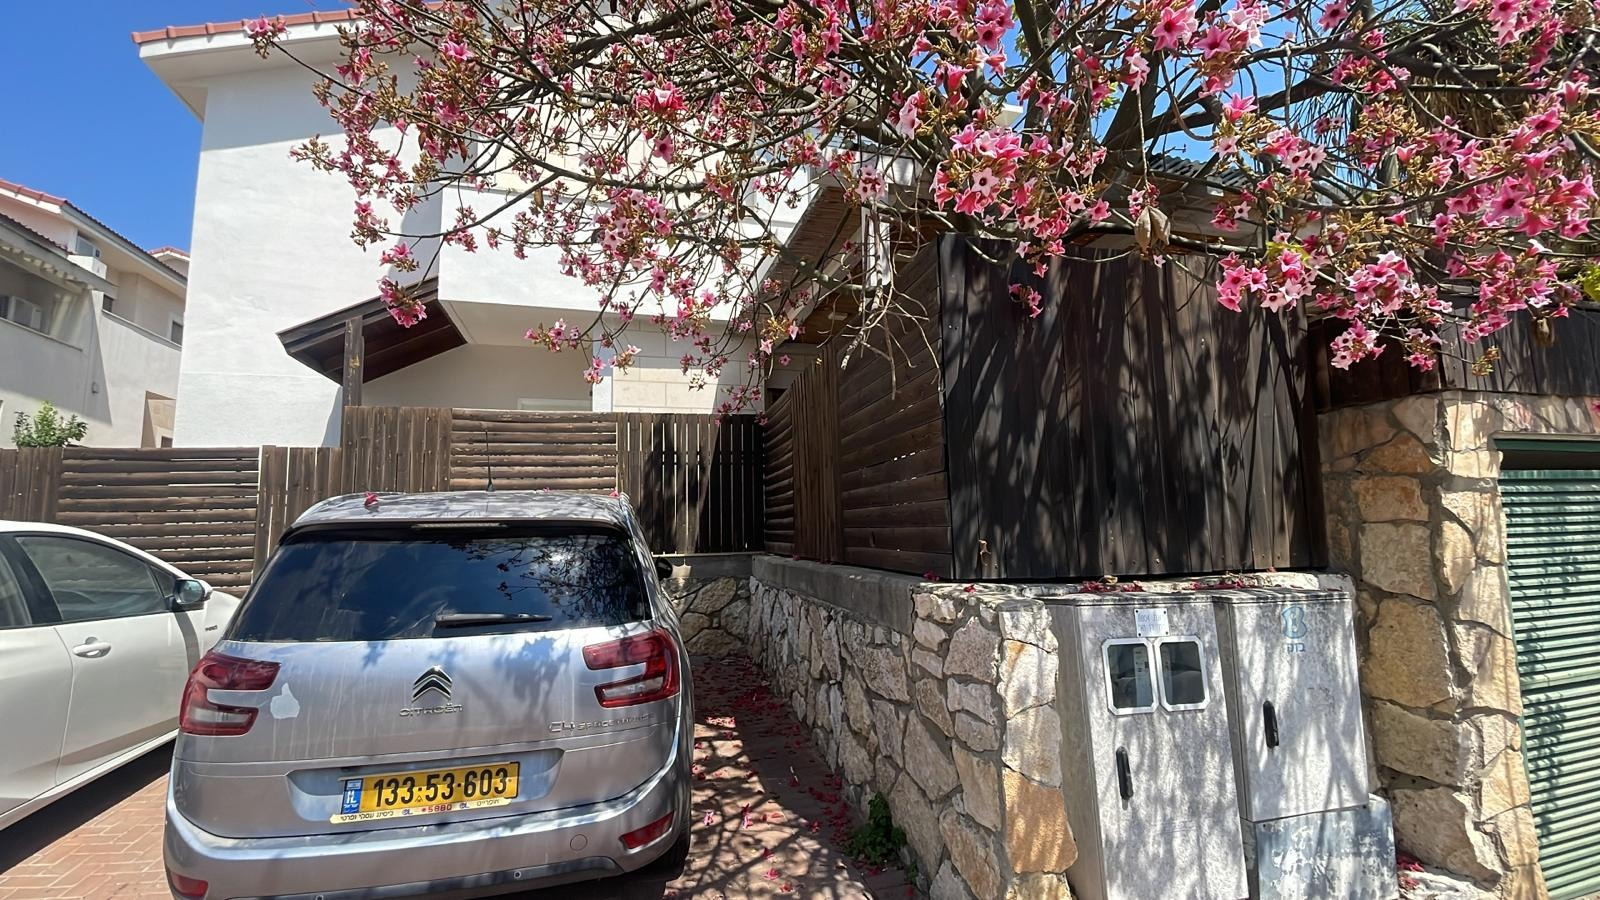


Example Object Image:


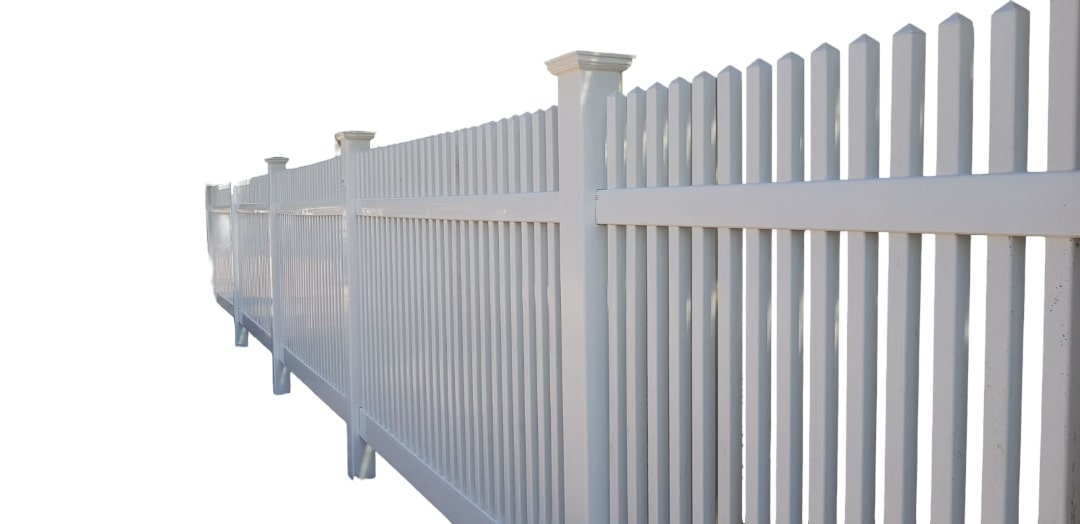

✓ Image loaded: inputs/initial.jpg
  - Size: (1600, 900)
  - Format: JPEG
  - Mode: RGB
✓ Image loaded: inputs/example.jpg
  - Size: (1080, 524)
  - Format: JPEG
  - Mode: RGB


In [45]:
# Load images
print("\n🖼️  Loading Images...")

# Display input images if they exist
display_input_images(INITIAL_IMAGE_PATH, EXAMPLE_IMAGE_PATH)

# Load image files for API
initial_image = load_and_validate_image(INITIAL_IMAGE_PATH)
example_image = load_and_validate_image(EXAMPLE_IMAGE_PATH)

if not initial_image or not example_image:
    print("\n⚠️  Missing image files. Please add:")
    print(f"- Initial image: {INITIAL_IMAGE_PATH}")
    print(f"- Example object image: {EXAMPLE_IMAGE_PATH}")
    print("\nThe notebook will continue with placeholder functionality.")

## OpenAI Image Edit Request Function
This function sends requests to OpenAI's image editing API, allowing you to generate modified versions of input images based on a text prompt. It handles the entire API interaction process including file preparation, request formatting, and response handling.

In [46]:

def send_edit_request(prompt: str,
                      images: list[str],
                      number_of_versions: int,
                      api_key: str,
                      model: str = 'gpt-image-1'):
    
    # Initialize tracking
    start_time = time.time()
    timestamp = datetime.now().isoformat()
    
    results = None
    
    try:
        files = []
        for image in images:
            files.append(('image[]', (os.path.basename(image), open(image, 'rb'), 'image/jpeg')))

        prompt = open(PROMPT_FILE_PATH, 'r').read().replace('\n', '')


        # Prepare the data
        data = \
            {
                'model': model,
                'prompt': prompt,
                'n': number_of_versions,
                'size': 'auto'
            }

        # Prepare headers (don't include Content-Type - requests will set it automatically for multipart)
        headers = \
            {
                'Authorization': f"Bearer {OPENAI_API_KEY}"
            }


        # Make the request
        response = requests.post(
            'https://api.openai.com/v1/images/edits',
            headers=headers,
            files=files,
            data=data)

        results_path = os.path.join(OUTPUT_DIR, 'response.json')
        results = response.json()
        
        print(f"""Saving results to {results_path}""")
        
        log_results(results, results_path)
    
    except Exception as e:
        print(f"❌ Error generating image: {e}")
    
    finally:
        end_time = time.time()
        execution_time = end_time - start_time
        
        print(f"Execution time: {execution_time:.2f} seconds")
        
        return results
    


## Execute Image Generation

In [47]:
number_of_versions = 1

# Check if we have all required inputs
if prompt and initial_image and example_image:
    print("🎬 All inputs ready. Starting generation...\n")
    
    images = [INITIAL_IMAGE_PATH, EXAMPLE_IMAGE_PATH]
    
    # Generate the image
    results = send_edit_request(prompt=prompt,
                                images=images,
                                number_of_versions=number_of_versions,
                                api_key=OPENAI_API_KEY,
                                model="gpt-image-1")
    
else:
    print("⚠️  Cannot proceed without all required inputs:")
    print(f"- Prompt: {'✓' if prompt else '❌'}")
    print(f"- Initial image: {'✓' if initial_image else '❌'}")
    print(f"- Example image: {'✓' if example_image else '❌'}")

🎬 All inputs ready. Starting generation...

Saving results to outputs/response.json
✓ Results logged to outputs/response.json
Execution time: 81.12 seconds


## Save and Display Results


💾 Saving generated image...
✅ Image saved to: outputs/version_1.jpg

🎨 Generated Image:


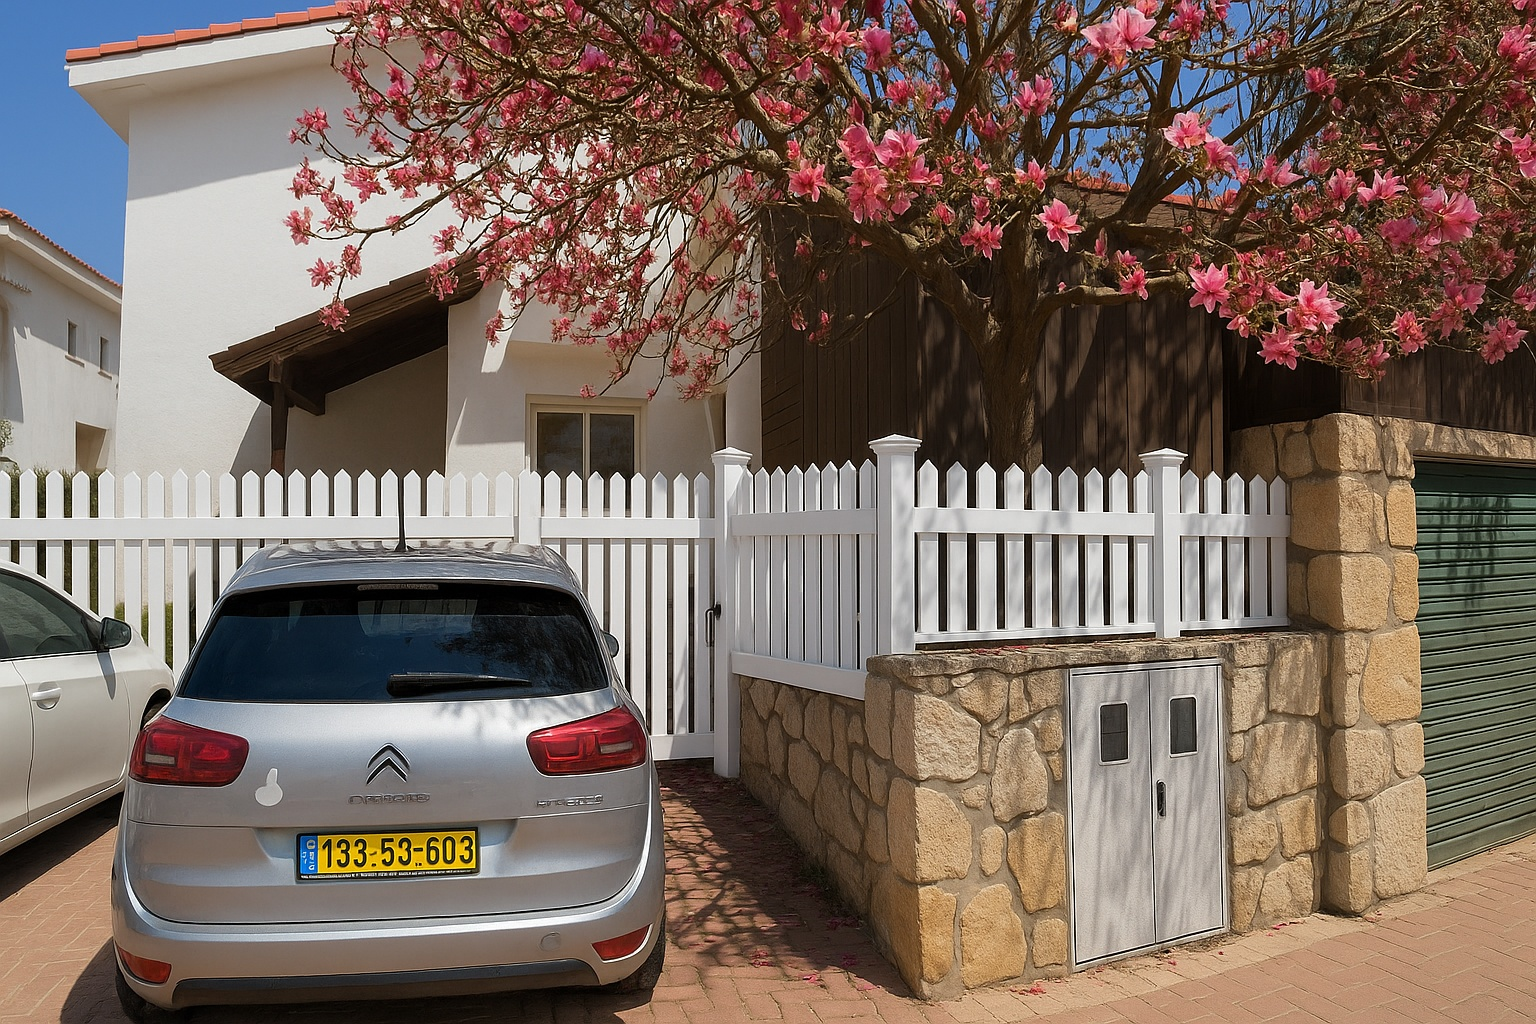

In [ ]:
if results and isinstance(results, dict):
    print("\n💾 Saving generated image...")
    
    # Save the generated image
    for n in range(number_of_versions):
        image_base64 = results["data"][n]["b64_json"]
        image_bytes = base64.b64decode(image_base64)
        
        # Save full resolution image
        image = Image.open(BytesIO(image_bytes))
        output_image_path = os.path.join(OUTPUT_DIR, f"version_{n+1}.jpg")
        image.save(output_image_path, format="JPEG", quality=95, optimize=True)
    
        print(f"✅ Image saved to: {output_image_path}")
    
        # Display the result
        print("\n🎨 Generated Image:")
        display(IPImage(output_image_path, width=500))
    
else:
    print("\n❌ No image was generated due to errors or missing inputs.")

## Results Summary

In [ ]:
print("\n📊 GENERATION SUMMARY")
print("=" * 50)

for key, value in tracking_results.items():
    if key == 'prompt_preview':
        print(f"📝 Prompt Preview: {value}")
    elif key == 'execution_time_seconds':
        print(f"⏱️  Execution Time: {value:.2f} seconds")
    elif key == 'estimated_cost_usd':
        print(f"💰 Estimated Cost: ${value:.4f} USD")
    elif key == 'success':
        status = "✅ SUCCESS" if value else "❌ FAILED"
        print(f"🎯 Status: {status}")
    elif key == 'error' and value:
        print(f"❌ Error: {value}")
    elif key not in ['prompt_preview', 'error']:
        print(f"{key.replace('_', ' ').title()}: {value}")

print("\n" + "=" * 50)
print(f"📁 Results logged to: {RESULTS_LOG_PATH}")
if tracking_results['success']:
    print(f"🖼️  Generated image saved to: {OUTPUT_IMAGE_PATH}")


📊 GENERATION SUMMARY
Timestamp: 2025-06-30T18:52:05.601810
Model: gpt-image-1
Size: auto
Quality: auto
Prompt Length: 27550
Estimated Tokens: 6887
💰 Estimated Cost: $0.0400 USD
⏱️  Execution Time: 77.33 seconds
🎯 Status: ✅ SUCCESS
📝 Prompt Preview: This document outlines the steps and specifications for creating a realistic simulation of a fence b...

📁 Results logged to: outputs/generation_results.json
🖼️  Generated image saved to: outputs/generated_image.jpg
